In [1]:
#TO DO - PLAY AROUND WITH SMT PARAMETERS UNTIL YOU GET SENSIBLE FA/MD! CAN MATCH SMT MAX/MIN TO HCP DATA FIT

#write simulation funct#[noiseless, directional] signal and model and ROImask [dti], set random seedion that outputs ground truth 


In [2]:
#load modules

import numpy as np
import matplotlib.pyplot as plt


In [3]:
#set the random seed so that you get the same simulations
np.random.seed(seed=1)

In [4]:
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()



/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from dmipy.distributions.distribute_models import BundleModel
bundle = BundleModel([stick, zeppelin])
bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bundle.set_equal_parameter('G2Zeppelin_1_mu', 'C1Stick_1_mu')



In [6]:
#set up two models - directional and direction averaged

from dmipy.core import modeling_framework
mc_smt_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[bundle])
mc_smt_mod.parameter_names


mc_mod = modeling_framework.MultiCompartmentModel(
    models=[bundle])
mc_mod.parameter_names



We highly recommend installing pathos to take advantage of multicore processing.
We highly recommend installing pathos to take advantage of multicore processing.


['BundleModel_1_G2Zeppelin_1_lambda_par',
 'BundleModel_1_G2Zeppelin_1_mu',
 'BundleModel_1_partial_volume_0']

In [7]:
#set up the ground truth parameter values in each ROI



#number of voxels for each tissue type
#n_wm = 40000
#n_gm = 20000
#n_csf = 10000 
n_wm = 500
n_gm = 300
n_csf = 100

ROImask_gt = np.concatenate((np.ones((n_wm,)),2*np.ones((n_gm,)),3*np.ones((n_csf,))))                      

#choose some parameters for the simulated SMT-NODDI model 
lambda_par_wm = [1.5e-9, 2.5e-9]
lambda_par_gm = [0.5e-9, 1.5e-9]
lambda_par_csf = [2.9e-9, 3e-9]
mu_1 = [0, np.pi]
mu_2 = [-np.pi,np.pi]
f_stick_wm = [0.6, 0.8]
f_stick_gm = [0.2, 0.4]
f_stick_csf = [0, 0.01]


lambda_par = np.concatenate((np.random.uniform(low=lambda_par_wm[0],high=lambda_par_wm[1], size = n_wm),
                      np.random.uniform(low=lambda_par_gm[0],high=lambda_par_gm[1], size = n_gm),
                      np.random.uniform(low=lambda_par_csf[0],high=lambda_par_csf[1], size = n_csf)))
              
f_stick = np.concatenate((np.random.uniform(low=f_stick_wm[0],high=f_stick_wm[1], size = n_wm),
                      np.random.uniform(low=f_stick_gm[0],high=f_stick_gm[1], size = n_gm),
                      np.random.uniform(low=f_stick_csf[0],high=f_stick_csf[1], size = n_csf)))

mu_1 = np.random.uniform(low=mu_1[0],high=mu_1[1],size=n_wm+n_gm+n_csf)
mu_2 = np.random.uniform(low=mu_2[0],high=mu_2[1],size=n_wm+n_gm+n_csf)

mu = np.stack((mu_1,mu_2),axis=1)

f_free = 1 - f_stick



# stick_par = np.concatenate((np.random.uniform(low=stick_par_wm[0],high=stick_par_wm[1], size = n_wm),
#                       np.random.uniform(low=stick_par_gm[0],high=stick_par_gm[1], size = n_gm),
#                       np.random.uniform(low=stick_par_csf[0],high=stick_par_csf[1], size = n_csf)))




#put into a big parameter vector that can be passed into simulate_signal
parameters_vector = mc_mod.parameters_to_parameter_vector(BundleModel_1_G2Zeppelin_1_mu=mu,
                                                                BundleModel_1_G2Zeppelin_1_lambda_par=lambda_par,
                                                                BundleModel_1_partial_volume_0=f_stick)
                                                        








In [8]:
#get the saved hcp scheme
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [9]:
#simulate the signal using the DIRECTIONAL model 

signals = mc_mod.simulate_signal(acq_scheme,parameters_vector)

from useful_functions import add_noise

signals = add_noise(signals,snr=50)


In [10]:
#calculate the ROImask using dipy

#set up the dipy aquisition
from dipy.core.gradients import gradient_table
gtab = gradient_table(acq_scheme.bvalues, acq_scheme.gradient_directions)

#
import dipy.reconst.dti as dti

tenmodel = dti.TensorModel(gtab)

tenfit = tenmodel.fit(signals)



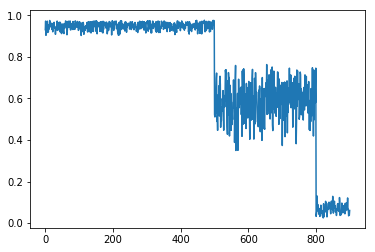

In [11]:
plt.plot(tenfit.fa)

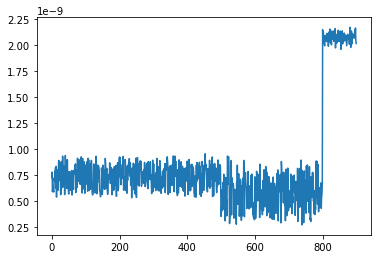

In [12]:
plt.plot(tenfit.md)

In [13]:
#threshold md and fa to estimate the ROImask
md_thresh = 1.5e-9
fa_thresh = 0.8

ROImask = np.zeros_like(ROImask_gt)

#white matter - less than md threshold and higher than fa threshold
ROImask[(tenfit.md < md_thresh) & (tenfit.fa > fa_thresh)] = 1
#grey matter - less than md threshold and less than fa threshold
ROImask[(tenfit.md < md_thresh) & (tenfit.fa < fa_thresh)] = 2
#csf - higher than md threshold and lower than fa threshold
ROImask[(tenfit.md > md_thresh) & (tenfit.fa < fa_thresh)] = 3




In [16]:
#fit the MC spherical mean model (CHECK AGAINST DIRECTION AVERAGING FIRST!)
mc_smt_mod_lsq_fit = mc_smt_mod.fit(acq_scheme, signals)


Setup brute2fine optimizer in 0.2357470989227295 seconds
Fitting of 900 voxels complete in 6.02646803855896 seconds.
Average of 0.0066960755983988445 seconds per voxel.


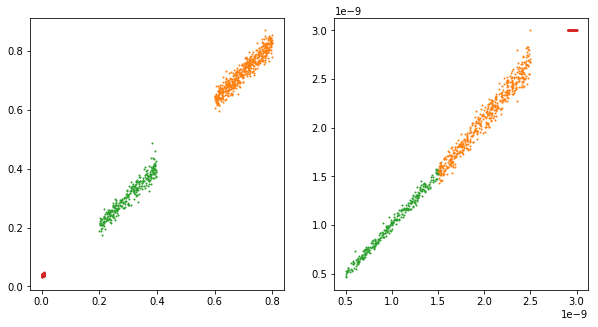

In [17]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for roi in range(0,int(np.max(ROImask))+1):
    axs[0].plot(f_stick[ROImask==roi],mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask==roi],'o',markersize=1)
        
    axs[1].plot(lambda_par[ROImask==roi],mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],'o',markersize=1)    


#axs[0].set_xlim([0,1])
#axs[0].set_ylim([0,1])

In [18]:
from useful_functions import create_spherical_mean_scheme
from dmipy.utils import spherical_mean

acq_scheme_smt = create_spherical_mean_scheme(acq_scheme)

#signals_sm = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals, acq_scheme) ] 
signals_sm = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals[i,:], acq_scheme) for i in range(0,n_wm+n_gm+n_csf)])





In [19]:
E_fit = mc_smt_mod.simulate_signal(acq_scheme_smt,mc_smt_mod_lsq_fit.fitted_parameters_vector)


In [20]:
import time 
import fit_bayes_new


nsteps=1000
burn_in=500
nupdates=20

# hierarchical Bayesian fitting
#proc_start = time.time()
parameters_bayes_dict, acceptance_rate, parameter_convergence, likelihood, weights\
    = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm, E_fit, mc_smt_mod_lsq_fit.fitted_parameters, ROImask, nsteps, burn_in, nupdates)
#compute_time(proc_start, time.time())






 >> at start of fit_bayes.fit
 >> extracting ROIs
 >> setting up dictionary
BundleModel_1_G2Zeppelin_1_lambda_par
BundleModel_1_partial_volume_0
 >> setting up weights
 >> initialising dictionaries
26
26
 >> starting loop
ROI 1/3; 500 voxels
mcmc step = 0/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 1/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 2/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 3/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 4/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 5/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 6/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 7/1000
param = Bun

mcmc step = 76/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 77/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 78/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 79/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 80/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 81/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 82/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 83/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 84/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 85/1000
param = BundleModel_1_G2Zeppelin_1_

mcmc step = 154/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 155/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 156/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 157/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 158/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 159/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 160/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 161/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 162/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 163/1000
param = BundleModel_1_G2Z

mcmc step = 232/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 233/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 234/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 235/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 236/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 237/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 238/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 239/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 240/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 241/1000
param = BundleModel_1_G2Z

mcmc step = 310/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 311/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 312/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 313/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 314/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 315/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 316/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 317/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 318/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 319/1000
param = BundleModel_1_G2Z

mcmc step = 388/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 389/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 390/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 391/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 392/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 393/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 394/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 395/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 396/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 397/1000
param = BundleModel_1_G2Z

mcmc step = 466/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 467/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 468/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 469/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 470/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 471/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 472/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 473/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 474/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 475/1000
param = BundleModel_1_G2Z

mcmc step = 544/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 545/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 546/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 547/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 548/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 549/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 550/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 551/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 552/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 553/1000
param = BundleModel_1_G2Z

mcmc step = 622/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 623/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 624/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 625/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 626/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 627/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 628/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 629/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 630/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 631/1000
param = BundleModel_1_G2Z

mcmc step = 700/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 701/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 702/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 703/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 704/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 705/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 706/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 707/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 708/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 709/1000
param = BundleModel_1_G2Z

mcmc step = 778/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 779/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 780/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 781/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 782/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 783/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 784/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 785/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 786/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 787/1000
param = BundleModel_1_G2Z

param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 856/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 857/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 858/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 859/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 860/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 861/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 862/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 863/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 864/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par


param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 934/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 935/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 936/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 937/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 938/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 939/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 940/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 941/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 942/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par


mcmc step = 11/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 12/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 13/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 14/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 15/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 16/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 17/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 18/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 19/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 20/1000
param = BundleModel_1_G2Zeppelin_1_

param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 90/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 91/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 92/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 93/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 94/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 95/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 96/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 97/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 98/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = B

mcmc step = 167/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 168/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 169/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 170/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 171/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 172/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 173/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 174/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 175/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 176/1000
param = BundleModel_1_G2Z

mcmc step = 245/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 246/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 247/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 248/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 249/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 250/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 251/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 252/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 253/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 254/1000
param = BundleModel_1_G2Z

mcmc step = 323/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 324/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 325/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 326/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 327/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 328/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 329/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 330/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 331/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 332/1000
param = BundleModel_1_G2Z

mcmc step = 401/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 402/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 403/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 404/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 405/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 406/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 407/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 408/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 409/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 410/1000
param = BundleModel_1_G2Z

mcmc step = 479/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 480/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 481/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 482/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 483/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 484/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 485/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 486/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 487/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 488/1000
param = BundleModel_1_G2Z

mcmc step = 557/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 558/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 559/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 560/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 561/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 562/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 563/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 564/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 565/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 566/1000
param = BundleModel_1_G2Z

mcmc step = 635/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 636/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 637/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 638/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 639/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 640/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 641/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 642/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 643/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 644/1000
param = BundleModel_1_G2Z

mcmc step = 713/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 714/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 715/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 716/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 717/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 718/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 719/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 720/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 721/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 722/1000
param = BundleModel_1_G2Z

mcmc step = 791/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 792/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 793/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 794/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 795/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 796/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 797/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 798/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 799/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 800/1000
param = BundleModel_1_G2Z

mcmc step = 869/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 870/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 871/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 872/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 873/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 874/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 875/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 876/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 877/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 878/1000
param = BundleModel_1_G2Z

mcmc step = 947/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 948/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 949/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 950/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 951/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 952/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 953/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 954/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 955/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 956/1000
param = BundleModel_1_G2Z

mcmc step = 25/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 26/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 27/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 28/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 29/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 30/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 31/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 32/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 33/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 34/1000
param = BundleModel_1_G2Zeppelin_1_

mcmc step = 103/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 104/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 105/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 106/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 107/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 108/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 109/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 110/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 111/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 112/1000
param = BundleModel_1_G2Z

mcmc step = 181/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 182/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 183/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 184/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 185/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 186/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 187/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 188/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 189/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 190/1000
param = BundleModel_1_G2Z

mcmc step = 259/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 260/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 261/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 262/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 263/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 264/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 265/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 266/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 267/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 268/1000
param = BundleModel_1_G2Z

mcmc step = 337/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 338/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 339/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 340/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 341/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 342/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 343/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 344/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 345/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 346/1000
param = BundleModel_1_G2Z

mcmc step = 415/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 416/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 417/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 418/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 419/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 420/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 421/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 422/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 423/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 424/1000
param = BundleModel_1_G2Z

param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 494/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 495/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 496/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 497/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 498/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 499/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 500/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 501/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 502/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par


mcmc step = 571/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 572/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 573/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 574/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 575/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 576/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 577/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 578/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 579/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 580/1000
param = BundleModel_1_G2Z

mcmc step = 649/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 650/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 651/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 652/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 653/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 654/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 655/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 656/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 657/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 658/1000
param = BundleModel_1_G2Z

param = BundleModel_1_partial_volume_0
mcmc step = 727/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 728/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 729/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 730/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 731/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 732/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 733/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 734/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 735/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc st

mcmc step = 804/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 805/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 806/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 807/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 808/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 809/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 810/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 811/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 812/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 813/1000
param = BundleModel_1_G2Z

param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 883/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 884/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 885/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 886/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 887/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 888/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 889/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 890/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 891/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par


mcmc step = 960/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 961/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 962/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 963/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 964/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 965/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 966/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 967/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 968/1000
param = BundleModel_1_G2Zeppelin_1_lambda_par
param = BundleModel_1_partial_volume_0
mcmc step = 969/1000
param = BundleModel_1_G2Z

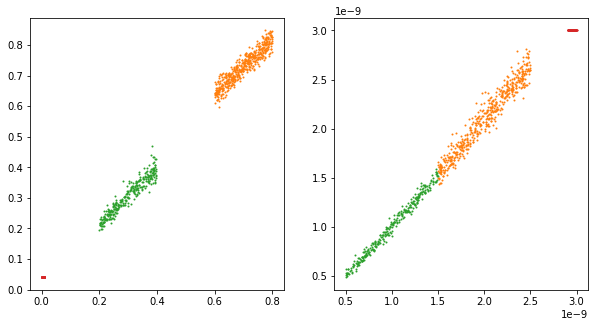

In [22]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for roi in range(0,int(np.max(ROImask))+1):
    axs[0].plot(f_stick[ROImask==roi],parameters_bayes_dict['BundleModel_1_partial_volume_0'][ROImask==roi],'o',markersize=1)
        
    axs[1].plot(lambda_par[ROImask==roi],parameters_bayes_dict['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],'o',markersize=1)    


#axs[0].set_xlim([0,1])
#axs[0].set_ylim([0,1])

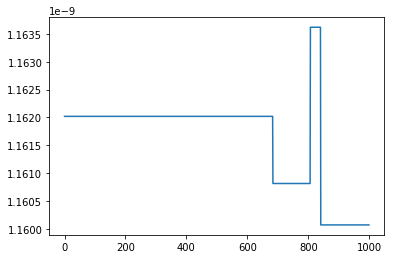

In [24]:
plt.plot(parameter_convergence['BundleModel_1_G2Zeppelin_1_lambda_par'][600,:])